# Starbucks Capstone Challenge

### [Medium Post](http://) 

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Problem Statement

Our main goal to be approached by the analysis:

1. What do we learn from the datasets: 
 - What does the customer's basic demographic distribution looks like, such as age and income ?
 - What is the effectiveness of the offers provided by Starbucks? (Successful rate)
 - Are there any demographic preference for the offers?    
 
 
2. Could we predict the target customers to improve the effectiveness in the future?
 - Prediction accuracy: How good of our prediction model?
 - Feature Importances: What are the main factors that define the usage of offers?


In [2]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import progressbar

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# read in the json files
portfolio = pd.read_json('data/portfolio.json',  orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Overview of datasets

In [3]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
profile.sample(5)

,gender,age,id,became_member_on,income
12270,M,45,7d47f3a573e34dadb223d70389da903f,20140609,94000.0
13484,O,77,9f87368b6d19434780c51ba9b45334e8,20171218,92000.0
11222,F,66,39736eee807a4ab1a9a08c642e530538,20160724,42000.0
16565,None,118,ce96fff5ef0a41e1a217728a81f6722a,20160322,NaN
1730,F,56,b991355e11ce45789521f22bcd12804a,20180222,80000.0


In [5]:
transcript.sample(5)

,person,event,value,time
243585,0673e9690e874b7b842da2be63d2de84,transaction,{'amount': 26.09},570
80771,ed45c5b6d69b4c17a7855caec289b021,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,198
244967,1a85ed00b630425aba646b057c6b0f18,transaction,{'amount': 1.9300000000000002},570
176251,d5da09de843d412b9739c08c5bd212c7,transaction,{'amount': 13.47},426
6666,a5016c17d5ef450482fa82c002896476,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


In [6]:
portfolio.shape, profile.shape, transcript.shape

((10, 6), (17000, 5), (306534, 4))

In [7]:
# check NaN values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

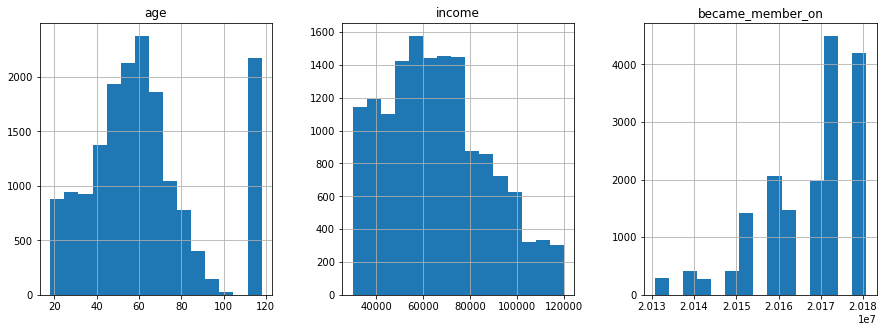

In [8]:
# A quick look at the data distribution 
profile.hist(column =['age', 'income', 'became_member_on'], layout=(1,3), figsize= (15, 5), bins =15);

In [9]:
# Customers with age 118
profile.query("age ==118")

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


Customers whose age are 118. It seems that these customers do not have gender and income information either. Actually 118 is a placeholder for those who do not want to provide their ages. 

M    8484
F    6129
O     212
Name: gender, dtype: int64


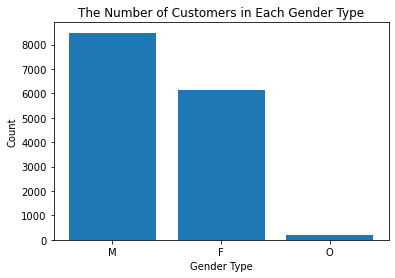

In [10]:
#Count of cusotmer based on gender
print(profile.gender.value_counts())

count = profile.gender.value_counts() 
x = ['M','F','O']
plt.bar(x, height=count)
plt.xlabel('Gender Type');
plt.ylabel('Count')
plt.title('The Number of Customers in Each Gender Type');

There are more male cusotmers than female customers.

In [11]:
# Check Null values
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [12]:
# value counts for different events
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [13]:
# Drop all those columns from the profile since there are no infomration about the gender and income 
profile =profile.query("age!=118")
profile.query("age==118")

,gender,age,id,became_member_on,income


### Data pre-process
* **profile dataset**: Extract year and month from become_member_year in to seperated columns
* **transcript dataset**: Extract the keys and values from column "value" in transcript and convert to seperated columns
* Combine three datasets into one based on 'customer id' and 'offer id'

In [14]:
#convert became_member_on to datetime type
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.dtypes

gender                      object
age                          int64
id                          object
became_member_on    datetime64[ns]
income                     float64
dtype: object

In [15]:
# Extract the year and month when become member 
profile['member_year']= profile['became_member_on'].dt.year
profile['mebmer_month']= profile['became_member_on'].dt.month
profile.head()

,gender,age,id,became_member_on,income,member_year,mebmer_month
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11


In [16]:
# find out all the dictionary keys in value column
keys = set()

for i in transcript['value']:
    for k, v in i.items():
        keys.add(k)
keys   

{'amount', 'offer id', 'offer_id', 'reward'}

In [17]:
# unpack information in 'value' column to separate column: 'amount', 'offer id', 'offer_id', 'reward'
temp = transcript['value'].apply(pd.Series)

#combine "offer_id" column and "offer id" column as one, and drop the other 
temp['offer_id'].fillna(temp['offer id'], inplace =True)
temp = temp.drop(columns=['offer id'])
transcript_new = pd.concat([transcript, temp], axis=1)
transcript_new.head()

,person,event,value,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [18]:
# drop the value column and rename reward as t_reward, person as person_id

transcript_new.drop(columns=['value'], inplace=True)
transcript_new.rename(columns={"reward": "t_reward", "person": "person_id"}, inplace=True)

#rename id as person_id in profile
profile.rename(columns={"id": "person_id"}, inplace=True)

In [19]:
# merge transcript_new with profile based on person id, 
#left join will be use caused we only need the customers made transactions

merged = pd.merge(transcript_new, profile, on= ['person_id'], how = 'left')
merged.head()

,person_id,event,time,amount,offer_id,t_reward,gender,age,became_member_on,income,member_year,mebmer_month
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,2017-05-09,100000.0,2017.0,5.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,M,68.0,2018-04-26,70000.0,2018.0,4.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaT,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaT,NaN,NaN,NaN


In [20]:
# merge again with portfolio based on offer ids, left join 
merged = pd.merge(merged, portfolio, left_on= ['offer_id'], right_on= ['id'], how = 'left')
merged = merged.drop(columns=['id'])

merged['event'].replace('offer_received', 'offer received')
#convert duration to hours
merged['duration'] = merged['duration']* 24
merged.sample(5)

,person_id,event,time,amount,offer_id,t_reward,gender,age,became_member_on,income,member_year,mebmer_month,reward,channels,difficulty,duration,offer_type
210173,b673e4cf251c498c9a8a0997874f6704,offer received,504,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,NaT,NaN,NaN,NaN,3.0,"[web, email, mobile, social]",7.0,168.0,discount
268310,49c4a0965ad04077bac189d20a88ec4e,offer viewed,588,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,M,79.0,2018-07-06,54000.0,2018.0,7.0,5.0,"[web, email, mobile, social]",5.0,120.0,bogo
161816,5176ddef3fe44ae59fd70ba2d08bff32,offer received,408,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN,NaT,NaN,NaN,NaN,3.0,"[web, email, mobile, social]",7.0,168.0,discount
34425,171c7f6ef14c416a87ac8907c58202ed,transaction,66,6.74,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306358,1ac8b6a96fdb46ef882e0d41818f8f2d,transaction,714,4.56,NaN,NaN,M,27.0,2014-01-20,74000.0,2014.0,1.0,NaN,NaN,NaN,NaN,NaN


In [21]:
merged.shape

(306534, 17)

### Exploratory analysis

**Distribution of customer demographic characters: gender: age, income, become_member_year**

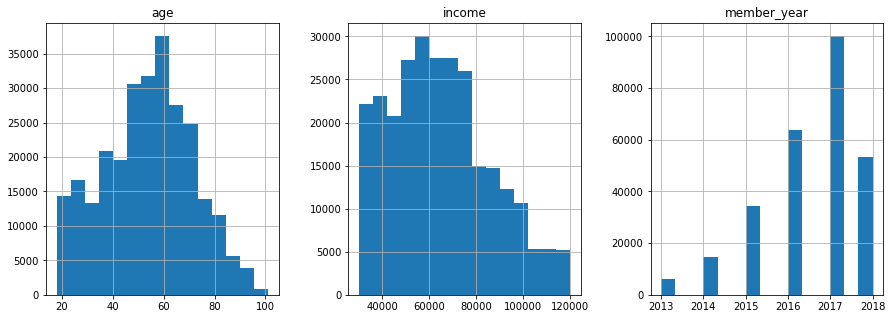

In [22]:
merged.hist(column =['age', 'income', 'member_year'], layout=(1,3), figsize= (15, 5), bins =15);

plt.savefig('Distribution.jpg')

In [23]:
#more male or female
merged.gender.value_counts(dropna=False)/merged.shape[0] *100

M      50.790451
F      36.896723
NaN    11.017375
O       1.295452
Name: gender, dtype: float64

There are more male than female customers. 

In [24]:
# To analysis the demographic preference on offer types, we create the dataset only contains offer event, no transactions

merged_offer = merged[merged['event'].isin(['offer received', 'offer viewed', 'offer completed'])]
merged_offer.head()

,person_id,event,time,amount,offer_id,t_reward,gender,age,became_member_on,income,member_year,mebmer_month,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75.0,2017-05-09,100000.0,2017.0,5.0,5.0,"[web, email, mobile]",5.0,168.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaT,NaN,NaN,NaN,5.0,"[web, email]",20.0,240.0,discount
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,M,68.0,2018-04-26,70000.0,2018.0,4.0,2.0,"[web, email, mobile]",10.0,168.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,NaT,NaN,NaN,NaN,2.0,"[web, email, mobile, social]",10.0,240.0,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,10.0,"[web, email, mobile, social]",10.0,120.0,bogo


In [25]:
merged_offer.gender.value_counts(dropna=False)/merged_offer.shape[0]

M      0.494662
F      0.380228
NaN    0.112041
O      0.013068
Name: gender, dtype: float64

**Questions: Are there any difference among genders on offers they received, viewed and completed.**

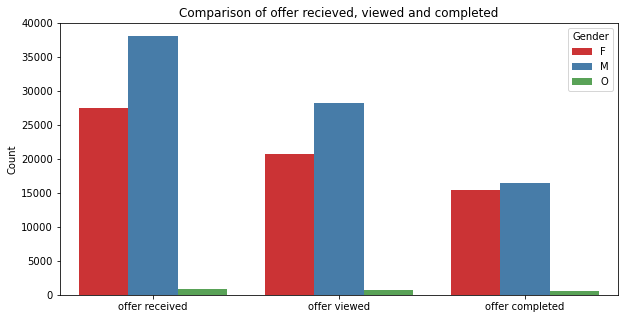

In [26]:
plt.figure(figsize=(10, 5))
g = sns.countplot(x="event", hue="gender", palette="Set1", data=merged_offer)
    
plt.title('Comparison of offer recieved, viewed and completed')
plt.ylabel('Count')
plt.xlabel('  ')
plt.legend(title='Gender')

plt.savefig("gender_offer.jpg")
plt.show();

More male customers received offers, as well as viewed offer, while the number of offer completed is similar. 

In [27]:
# compare the completed rates, offer completed/ offer received
# merged_offer.groupby(['gender']).event.value_counts()

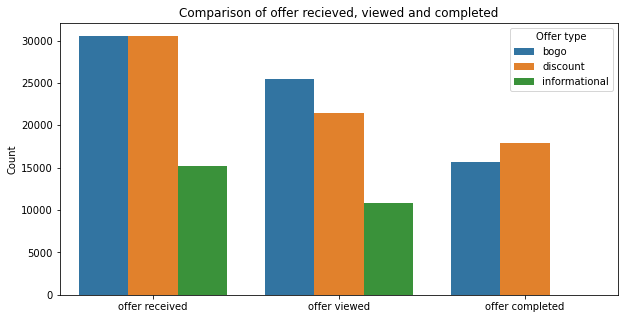

In [28]:
# Events for each offer type
plt.figure(figsize=(10, 5))
g = sns.countplot(x="event", hue="offer_type", palette="tab10", data=merged_offer)
    
plt.title('Comparison of offer recieved, viewed and completed')
plt.ylabel('Count')
plt.xlabel(' ')
plt.legend(title='Offer type')
plt.savefig('offer_type_action.jpg')
plt.show()

There are much more bogo and discount being sent out and viewed than informational offer. Between the two, they have equeal number of offers send to customer, while a slight more bogo were viewed but less completed.

**Questions: How much are the spend on starbucks?**

In [29]:
#Only select the rows of 'transaction'
merged_amount = merged[~merged['amount'].isnull()]
merged_amount.head()

,person_id,event,time,amount,offer_id,t_reward,gender,age,became_member_on,income,member_year,mebmer_month,reward,channels,difficulty,duration,offer_type
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83,NaN,NaN,F,20.0,2016-07-11,30000.0,2016.0,7.0,NaN,NaN,NaN,NaN,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56,NaN,NaN,M,42.0,2016-01-17,96000.0,2016.0,1.0,NaN,NaN,NaN,NaN,NaN
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23,NaN,NaN,M,36.0,2017-12-28,56000.0,2017.0,12.0,NaN,NaN,NaN,NaN,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51,NaN,NaN,F,55.0,2017-10-16,94000.0,2017.0,10.0,NaN,NaN,NaN,NaN,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97,NaN,NaN,F,39.0,2017-12-17,67000.0,2017.0,12.0,NaN,NaN,NaN,NaN,NaN


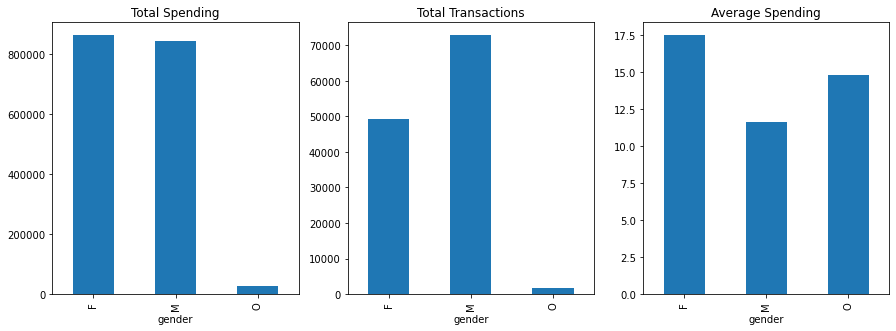

In [30]:
#Who spend more money on average

total = merged_amount.groupby(['gender']).amount.sum()
counts = merged_amount.groupby(['gender']).amount.count()
ave = merged_amount.groupby(['gender']).amount.mean()
x=['F', 'M', 'O']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
total.plot(ax=axes[0], kind='bar')
axes[0].set_title('Total Spending')

counts.plot(ax=axes[1], kind='bar')
axes[1].set_title('Total Transactions')
ave.plot(ax=axes[2], kind='bar')
axes[2].set_title('Average Spending') 
plt.savefig("gender_offer.jpg")
plt.show();

The total amount of money spend by both gender is similar. However, although male made much transactions than female, the average cost per transaction is lower. 

### Define the Success or Failed offer  

Here is the challenge question: Could we point out which offer has impact on buyer's behavior?

I consider an offer is successful as following:

For bogo and discount, offer received -> offer viewed -> offer completed

For informational offer, offer received -> offer viewed -> transactions 

In both situation, these events should happen within the duration period and the order should not be changed. 

Other than that, offers should be take as failed and has no impact on customer's decision. 

Concerns need to be aware:
One person could receive the same type of offer more than once,
Another offer recieved before current offer is completed. 

In [31]:
# take a look at the transaction for single person_id 
# merged[merged['person_id'] =='bb3983180f0f4b019976c13d5106ce11']

In [32]:
def offer_sucess_define(df):
    """
    Function to define which offer received by the customers are successful. Successful path are defined as following:
    for bogo and discount: offer received → offer viewed → offer completed
    for informational: offer received → offer viewed → transaction
    All events should happen within the validity period of the offer.
    
    INPUT:
  
    Dataframe - dataframe with all rows of offer events and transaction
    
    OUTPUT:
    Dataframe - dataframe with column "success", where a successful offer will be 1, failed as 0
    
    """
    
    # get the index of all 'offer received' rows in the dataframe 
    total_offers_received_idx = np.where(df['event'] == 'offer received')[0].tolist()
    
    n_person = len(df.person_id.unique())
    cnter=0
    bar=progressbar.ProgressBar(maxval=n_person+1, widgets =[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()

    for person in df.person_id.unique():
        cnter+=1
        bar.update(cnter)

        #dataframe for a single customer
        temp1 = df[df['person_id']==person]

        # get index of 'offer received' of  'offer_id' for this person as a list
        offers_received_idx = np.intersect1d(temp1.index, total_offers_received_idx)
        offer_id_list= temp1.loc[offers_received_idx]['offer_id'].tolist()

        for offer_id, offer_received_idx in zip(offer_id_list, offers_received_idx): 
            
            #type of the offer
            receive_offer_type = temp1.loc[offer_received_idx]['offer_type']
            
            #calcaulate single offer start and end time 
            time_received = temp1.loc[offer_received_idx]['time']
            duration_time = temp1.loc[offer_received_idx]['duration']

            #all rows (activities) within the duration window   
            temp2 = temp1.loc[offer_received_idx:]
            temp2 = temp2[temp2['time'] <= (time_received + duration_time)]

            if temp2.loc[offer_received_idx]['offer_type'] in ['bogo', 'discount']:

                #check whether this offer is viewed and completed
                try: 
                    # closest viewed offer
                    time_viewed = (temp2[(temp2['event']=='offer viewed') & (temp2['offer_id']==offer_id)]['time'].tolist())[0]
                    
                    offer_viewd_idx = temp2[(temp2['event']=='offer viewed') & (temp2['offer_id']==offer_id)].index[0]
                    temp3 = temp2.loc[offer_viewd_idx:]
                    #find the offer completed after reviewed 
                    time_completed = (temp3[(temp3['event']=='offer completed') & (temp3['offer_id']==offer_id)]['time'].tolist())[0]
                    
                    # the order of time for each activity: received-> viewed-> completed, this could happen in the same day
                    if (time_completed <= (time_received+duration_time)):
                        
                        #mark success as 1
                        df.loc[offer_received_idx, 'success'] = 1
                    else:
                        df.loc[offer_received_idx, 'success'] = 1

                except:
                    #mark failed as 0
                    df.loc[offer_received_idx, 'success'] = 0
            #informational offer       
            elif temp2.loc[offer_received_idx]['offer_type'] == 'informational':

                try: 
                    #check whether this offer is viewed and have a transaction within the duration time
                    time_viewed = (temp2[(temp2['event']=='offer viewed') & (temp2['offer_id']==offer_id)]['time'].tolist())[0]
                    offer_viewd_idx = temp2[(temp2['event']=='offer viewed') & (temp2['offer_id']==offer_id)].index[0]
                    
                    temp3 = temp2.loc[offer_viewd_idx:]
                    
                    #find the closest transaction time after reviewed 
                    time_transaction = (temp3[temp3['event']=='transaction']['time'].tolist())[0]
                    if (time_transaction <= (time_received+duration_time)):
                        df.loc[offer_received_idx, 'success'] = 1
                        
                    else:
                        df.loc[offer_received_idx, 'success'] = 0
                except:
                    df.loc[offer_received_idx, 'success'] = 0

            else:
                pass
    bar.finish()        
    return df


In [33]:
merged2 = offer_sucess_define(merged)

[=========================================================================] 100%


### Questions:
How much offer are send out for each type of offer?      
Could we calculate the success rate?   
Are the success rate different between genders or offer types? 

In [34]:
# To answer the above question, I only select rows of 'offers received' 
received_offers = merged2[merged2['event' ]== 'offer received']
received_offers.shape

(76277, 18)

In [35]:
received_offers.groupby([ 'success'])['success'].count()

success
0.0    46455
1.0    29822
Name: success, dtype: int64

In [36]:
count = received_offers.groupby(['success'])['success'].count()
print(f'Total offers: {count[1] +count[0]}, Success offers : {count[1]}, Failed offers : {count[0]}, success rate: {(count[1]/(count[0]+count[1])) * 100}')

Total offers: 76277, Success offers : 29822, Failed offers : 46455, success rate: 39.096975497200994


In [37]:
# Success rates by gender 
received_offers.groupby(['gender', 'success'])['gender'].count()

gender  success
F       0.0        14671
        1.0        12785
M       0.0        23250
        1.0        14879
O       0.0          438
        1.0          478
Name: gender, dtype: int64

In [38]:
g = received_offers.groupby(['gender', 'success'])['gender'].count().tolist()
print(f'Female {g[1]/ (g[0]+g[1]) * 100}, Male {g[3]/ (g[2]+g[3]) * 100},  O {g[5]/ (g[4]+g[5]) * 100}.')

Female 46.565413752913756, Male 39.02279105143067,  O 52.183406113537124.


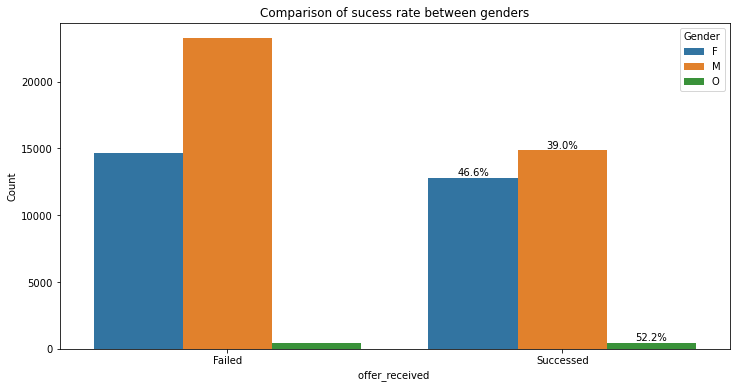

In [39]:
plt.figure(figsize=(12, 6))
ax= sns.countplot(x="success", hue="gender", palette="tab10", data=received_offers)
    
plt.title('Comparison of sucess rate between genders')
plt.ylabel('Count')
plt.xticks(range(2), ['Failed', 'Successed'])
plt.xlabel('offer_received ')
plt.legend(title='Gender', loc='upper right')


rects = ax.patches

# Make some labels.
labels = ['', '46.6%','',  '39.0%','', '52.2%']

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
    
plt.savefig('offer_success_gender.jpg')
plt.show()

In [40]:
# Success rates by offer type
received_offers.groupby(['offer_type', 'success'])['offer_type'].count()


offer_type     success
bogo           0.0        19351
               1.0        11148
discount       0.0        17827
               1.0        12716
informational  0.0         9277
               1.0         5958
Name: offer_type, dtype: int64

In [41]:
o = received_offers.groupby(['offer_type', 'success'])['offer_type'].count().tolist()

print(f'bogo {o[1]/ (o[0]+o[1]) * 100}, discount {o[3]/ (o[2]+ o[3]) * 100}, informational {o[5]/ (o[4]+o[5]) * 100}.')

bogo 36.552018098954065, discount 41.63310742232263, informational 39.10731867410568.


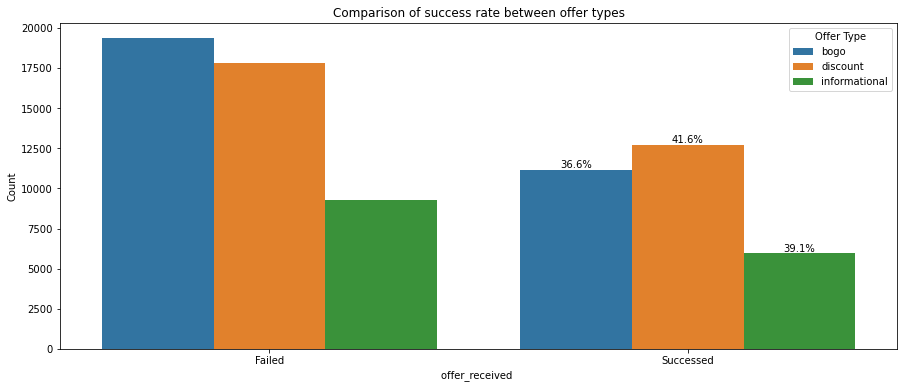

In [42]:
plt.figure(figsize=(15, 6))
ax =sns.countplot(x="success", hue="offer_type", palette="tab10", data=received_offers)
    
plt.title('Comparison of success rate between offer types')
plt.ylabel('Count')
plt.xticks(range(2), ['Failed', 'Successed'])
plt.xlabel('offer_received ')
plt.legend(title='Offer Type', loc='upper right')

rects = ax.patches

# Make some labels.
labels = ['', '36.6%','',  '41.6%','', '39.1%']

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
    
plt.savefig('offer_success_offer_type.jpg')
plt.show()

## Model to Predicting Offer Success

Before building the prediction model, further data process is needed:

1. Dataset only contains rows of "offer received" will be used.    
2. Age and income would be convert to group of data range.
3. Gender, member_year, channels, offer_type will transforme to dummy columns
4. Numerical value need to be scaled:   duration,  reward,  mebmer_month  
5. Columns to drop : 'person_id', 'event','amount', 'offer_id', 't_reward', 'diffculty' and the original rows after converted
5. Drop rows wiht null value

In [43]:
merged2.columns

Index(['person_id', 'event', 'time', 'amount', 'offer_id', 't_reward',
       'gender', 'age', 'became_member_on', 'income', 'member_year',
       'mebmer_month', 'reward', 'channels', 'difficulty', 'duration',
       'offer_type', 'success'],
      dtype='object')

In [44]:
df_model= received_offers.drop(columns=['person_id', 'event','amount', 'offer_id', 't_reward', 'became_member_on', 'difficulty'])
df_model.head()

,time,gender,age,income,member_year,mebmer_month,reward,channels,duration,offer_type,success
0,0,F,75.0,100000.0,2017.0,5.0,5.0,"[web, email, mobile]",168.0,bogo,1.0
1,0,NaN,NaN,NaN,NaN,NaN,5.0,"[web, email]",240.0,discount,0.0
2,0,M,68.0,70000.0,2018.0,4.0,2.0,"[web, email, mobile]",168.0,discount,0.0
3,0,NaN,NaN,NaN,NaN,NaN,2.0,"[web, email, mobile, social]",240.0,discount,0.0
4,0,NaN,NaN,NaN,NaN,NaN,10.0,"[web, email, mobile, social]",120.0,bogo,0.0


In [45]:
# drop rows with nan values, these rows lack of basic information of the customers
df_model.dropna(inplace=True)

# convert value of age, income and year to groups
df_model['age_group']  = pd.cut(df_model['age'], bins = [15,25,35,45,55,65,75,85,95,105], labels =[1, 2, 3, 4, 5,6,7,8, 9])
df_model['income_group']  = pd.cut(df_model['income'], bins = np.arange(20000, 130000, 10000), labels =[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
df_model['year_group']  = (df_model['member_year'] - 2012).astype(int)

#convert categorical values: gender, offer types and channels
offer_types = pd.get_dummies(df_model.offer_type)
df_model = pd.concat([df_model, offer_types], axis=1)

gender_types = pd.get_dummies(df_model.gender)
df_model = pd.concat([df_model, gender_types], axis=1)

for i in ['web', 'email', 'mobile', 'social']:
    df_model[i] = df_model['channels'].apply(lambda x: 1 if i in x else 0)
    
#drop original columns 
df_model = df_model.astype({"mebmer_month": int})
df_model.drop(columns= ['gender', 'age', 'income', 'member_year', 'channels', 'offer_type'], inplace=True)

In [46]:
df_model.head()

,time,mebmer_month,reward,duration,success,age_group,income_group,year_group,bogo,discount,informational,F,M,O,web,email,mobile,social
0,0,5,5.0,168.0,1.0,6,8,5,1,0,0,1,0,0,1,1,1,0
2,0,4,2.0,168.0,0.0,6,5,6,0,1,0,0,1,0,1,1,1,0
5,0,2,5.0,120.0,1.0,5,4,6,1,0,0,0,1,0,1,1,1,1
7,0,11,0.0,96.0,0.0,5,4,5,0,0,1,0,1,0,1,1,1,0
8,0,9,5.0,240.0,0.0,5,4,5,0,1,0,1,0,0,1,1,0,0


In [47]:
# 
X = df_model.drop(columns = ['success'])
Y = df_model['success']

In [48]:
# scale some features
scaler = MinMaxScaler()
features = ['mebmer_month', 'reward', 'reward', 'duration', 'age_group', 'income_group', 'year_group']

X[features] = scaler.fit_transform(X[features])
X.head()

,time,mebmer_month,reward,duration,age_group,income_group,year_group,bogo,discount,informational,F,M,O,web,email,mobile,social
0,0,0.363636,0.5,0.571429,0.625,0.777778,0.8,1,0,0,1,0,0,1,1,1,0
2,0,0.272727,0.2,0.571429,0.625,0.444444,1.0,0,1,0,0,1,0,1,1,1,0
5,0,0.090909,0.5,0.285714,0.500,0.333333,1.0,1,0,0,0,1,0,1,1,1,1
7,0,0.909091,0.0,0.142857,0.500,0.333333,0.8,0,0,1,0,1,0,1,1,1,0
8,0,0.727273,0.5,1.000000,0.500,0.333333,0.8,0,1,0,1,0,0,1,1,0,0


In [49]:
# Split training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [50]:

def Classification_report (classifier = None):
    """
    Builds classification model and print out report
    
    INPUT:
  
    classifier - the model to be used(default:None)
    
    OUTPUT:
    classifier - the classification model
    
    """
    
    classifier.fit(X_train, y_train)
    
    model_predictions = classifier.predict(X_test)
    
    print("Report: ", classification_report(y_test, model_predictions))
    print("Overall accuracy: ", accuracy_score(y_test, model_predictions))
    
    return classifier

In [62]:
for i in [ RandomForestClassifier(max_depth=20, random_state=42), GradientBoostingClassifier(random_state=42), AdaBoostClassifier(random_state=42)]:
    print(i)
    Classification_report (classifier = i)
    print('\n')


RandomForestClassifier(max_depth=20, random_state=42)
Report:                precision    recall  f1-score   support

         0.0       0.69      0.73      0.71      9552
         1.0       0.61      0.56      0.58      7074

    accuracy                           0.66     16626
   macro avg       0.65      0.64      0.64     16626
weighted avg       0.65      0.66      0.65     16626

Overall accuracy:  0.656922891856129


GradientBoostingClassifier(random_state=42)
Report:                precision    recall  f1-score   support

         0.0       0.70      0.81      0.75      9552
         1.0       0.67      0.53      0.59      7074

    accuracy                           0.69     16626
   macro avg       0.69      0.67      0.67     16626
weighted avg       0.69      0.69      0.68     16626

Overall accuracy:  0.6900036088054854


AdaBoostClassifier(random_state=42)
Report:                precision    recall  f1-score   support

         0.0       0.69      0.79      0.74      95

GradientBoostingClassifier has the highest accracy at 0.69.

In [55]:
# Hyperparameter tuning

def best_param_selection(X=X, Y=Y, classifier = None, param_grid=None):
    '''
    Find out the best parameter for the given classifier and return report
    
    INPUT:
    - X,Y: training datasets for X and y
    - classifier: the model to be used(default:None)
    - param_grid: dictionary contains paramemer to be screened 
    
    OUTPUT:
    - Print out of the Classification_report of the classifier
    - dictionary with best parameters for the classifier
    '''
    
    grid_search = GridSearchCV(classifier, param_grid)
    grid_search.fit(X, Y)
    best_params = grid_search.best_params_
    report = Classification_report(classifier)
    return best_params

In [60]:
# grid search of the best parameter
param_grid={
            'max_depth' : [ 3, 5, 9],
            'n_estimators': [20, 50, 100],
            "learning_rate":[0.1, 0.5, 1]
            }

best_params = best_param_selection(X,Y, GradientBoostingClassifier(random_state=42), param_grid)

Report:                precision    recall  f1-score   support

         0.0       0.70      0.81      0.75      9552
         1.0       0.67      0.53      0.59      7074

    accuracy                           0.69     16626
   macro avg       0.69      0.67      0.67     16626
weighted avg       0.69      0.69      0.68     16626

Overall accuracy:  0.6900036088054854


In [61]:
print(best_params)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


After applying the best parameters to the model, unfortunately the accuracy did not raise as expected. So I kept the default parameters. 

In [63]:
#Feature importances plot

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

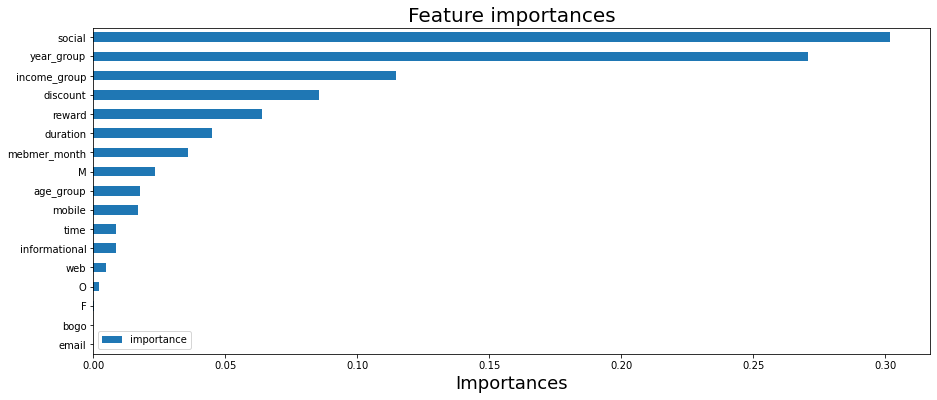

In [64]:

sorted(gb.feature_importances_)
feature_importances = pd.DataFrame(gb.feature_importances_,
                                   index = X.columns, 
                                    columns=['importance']).sort_values('importance',ascending=False)


feature_importances.plot.barh(figsize = (15, 6)).invert_yaxis()
plt.xlabel('Importances', fontsize=18)
# plt.ylabel('Importances', fontsize=18)
plt.title('Feature importances', fontsize=20);

plt.savefig('features.jpg');

I successfuly builde a predict model based on offer and customer information.  Among three most popular algorithoms, GradientBoostingClassifier works the best.

Our model has an accuracy of 69%, which is useful for the marketing team, although there is certainly room to improvement.


The most relevant features for offer success  are social and year, then followed by Income, discount, reward and duration. 


# Conclusion

Distribution of promotions/coupons to the clients become routine nowadays for many companies who want to expand their business.  Finding out the right clients who might be interested in would reduce the cost and increase their revenue. 
In the current analysis, I have explored the datasets from multiple aspects. Here is a summary of my findings: 
-	Most of Customers’ income ranges from 40,000 to 100,000 and age ranges from 20 to 80.
-	 There is gender preference in both offer action events and spending patterns. Man receives more offers but with less completed offer and spend less than woman on average. 
-	The differences of offer success rate are existed in both gender and offer types. Women again are more likely to redeem an offer than men. Among offer types, bogo has the highest success rate and informational offer had the lowest. 
-	The top relevant features are social, income range, year_become_member, discount offer, offer reward and duration. 

 
### Reflection  
 
After defining a success offer case, the most challenge part is how to differentiate these offers.  There are many scenarios need to be aware of during writing the function.  For example, one person could receive the same type of offer more than once; another offer received before current offer is completed; Although happens in the same day, which happens first, view offer or complete offer. It does spend a fair amount of time and debugging to deal with these scenarios. 

### Improvement  

- My prediction model does not take the customers’ transactions events into consideration. However, the pattern of a customer to make transaction could be significant in predicting the offers to be completed. Would a frequently coffee buyer like to receive offers and use them? Are there customers who want to complete the offer but the amount they spend is not enough?  One of the best practices to leverage our analysis is to create new variables that represent those data.
- I do not separate the customers who did purchases without knowing the offer, that is offer completed with offer viewed or viewed later.  If the company continue to send offers to these customers, it will potentially reduce the overall profit. Another model to predict these customers is also needed. 
